In [80]:
import numpy as np
import pandas as pd
import pickle

import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import KFold

pd.set_option('display.max_columns', None)

In [81]:
pickle_in = open("processed_film_data","rb")
film_df = pickle.load(pickle_in)

In [82]:
film_df.head()

,actors,budget,countries,directors,genres,gross_usa,languages,mpaa,rating,runtime,votes,writers
0,"[Tom Selleck, Laura San Giacomo, Alan Rickman]",20000000,+_+Australia+_+USA,Simon Wincer,"[Action, Adventure, Drama, Romance, Western]",21413105,"[English, Aboriginal]",PG-13,6.8,119.0,16501,John Hill
1,"[Kevin Costner, Mary McDonnell, Graham Greene]",22000000,+_+USA+_+UK,Kevin Costner,"[Adventure, Drama, Western]",184208848,"[English, Sioux, Pawnee]",PG-13,8.0,181.0,204981,Michael Blake
2,"[Tony Todd, Patricia Tallman, Tom Towles]",4200000,+_+USA,Tom Savini,[Horror],5835247,[English],R,6.9,92.0,33738,John A. Russo
3,"[Jonathan Brandis, Kenny Morrison, Clarissa Burt]",36000000,+_+USA+_+Germany,George Miller,"[Adventure, Drama, Family, Fantasy]",17373527,[English],PG,5.1,90.0,20152,Karin Howard
4,"[David Andrews, Kelly Wolf, Stephen Macht]",10500000,+_+USA+_+Japan,Ralph S. Singleton,[Horror],11582891,[English],R,4.8,89.0,7824,Stephen King


In [83]:
#Delete the rows I won't use
del film_df['actors']
del film_df['countries']
del film_df['writers']

In [84]:
#Create dummy columns for genres
genres = film_df['genres'].str.join('|').str.get_dummies()
genres.reset_index(drop=True, inplace=True)
film_df = pd.concat([film_df, genres], axis=1)
del film_df['genres']

In [85]:
#Create dummy columns for mpaa
mpaa = film_df['mpaa'].str.get_dummies()
mpaa.reset_index(inplace=True, drop=True)
film_df = pd.concat([film_df, mpaa], axis=1)
del film_df['mpaa']

In [86]:
#Create dummy columns for languages
languages = film_df['languages'].str.join('|').str.get_dummies()

In [87]:
#Check the values
languages.sum().sort_values(ascending = False).head(10)

English     4453
Spanish      446
French       328
German       195
Italian      165
Russian      157
Japanese     102
Arabic        87
Mandarin      78
Latin         53
dtype: int64

In [88]:
#Pick the top 7 languages and add them back to the dataframe
languages = languages[['English', 'Spanish', 'French', 'German', 'Italian', 'Russian', 'Japanese']]
film_df = pd.concat([film_df, languages], axis=1)
del film_df['languages']

In [89]:
#Look at director percentiles
film_df['directors'].value_counts().quantile(0.9)

5.0

In [90]:
#Create dummy columns for directors and delete all who have fewer than 5 films.
directors = film_df['directors'].str.get_dummies()
directors = directors[directors.columns[directors.sum() >=5]]
film_df = pd.concat([film_df, directors], axis=1)
del film_df['directors']

In [91]:
#Apply log based on previous observations (based on observations in Modeling 1)
film_df['budget'] = film_df['budget'].apply(lambda x: np.log(x))
film_df['gross_usa'] = film_df['gross_usa'].apply(lambda x: np.log(x))
film_df['runtime'] = film_df['runtime'].apply(lambda x: np.log(x))
film_df['votes'] = film_df['votes'].apply(lambda x: np.log(x))

In [92]:
#Scale data
scaler = MinMaxScaler()

data = film_df.drop('rating', axis=1)
target = film_df['rating']

data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

In [93]:
#Look at the correlation matrix
film_df.corr()

,budget,gross_usa,rating,runtime,votes,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,G,NC-17,NOT RATED,PG,PG-13,R,TV-14,TV-G,TV-MA,TV-PG,UNRATED,English,Spanish,French,German,Italian,Russian,Japanese,Adam McKay,Adam Shankman,Alan Parker,Alex Proyas,Alexander Payne,Alfonso Cuarón,Andrew Davis,Andrew Fleming,Andrzej Bartkowiak,Andy Fickman,Andy Tennant,Ang Lee,Anne Fletcher,Antoine Fuqua,Barbet Schroeder,Barry Levinson,Barry Sonnenfeld,Ben Stiller,Betty Thomas,Bill Condon,Boaz Yakin,Bobby Farrelly,Brad Bird,Brad Silberling,Brett Ratner,Brian De Palma,Brian Helgeland,Brian Levant,Brian Robbins,Bruce Beresford,Bryan Singer,Cameron Crowe,Carlos Saldanha,Catherine Hardwicke,Chris Columbus,Christopher Nolan,Clint Eastwood,Curtis Hanson,D.J. Caruso,Danny Boyle,Darren Aronofsky,David Ayer,David Dobkin,David Fincher,David Gordon Green,David Koepp,David O. Russell,David R. Ellis,David Twohy,David Yates,David Zucker,Dennis Dugan,Dominic Sena,Donald Petrie,Doug Liman,Edward Burns,Edward Zwick,Eli Roth,Ernest R. Dickerson,Ethan Coen,F. Gary Gray,Francis Ford Coppola,Francis Lawrence,Frank Coraci,Frank Oz,Garry Marshall,Gary Fleder,Gavin O'Connor,George Clooney,George Tillman Jr.,Gore Verbinski,Guillermo del Toro,Gus Van Sant,Guy Ritchie,Harald Zwart,Harold Ramis,Howard Deutch,Hugh Wilson,Irwin Winkler,Ivan Reitman,J.J. Abrams,Jake Kasdan,James Foley,James Gray,James Ivory,James Mangold,James Wan,Jan de Bont,Jason Reitman,Jaume Collet-Serra,Jay Roach,Joe Carnahan,Joe Johnston,Joe Wright,Joel Coen,Joel Schumacher,John Carpenter,John Dahl,John Lasseter,John Madden,John McTiernan,John Moore,John Sayles,John Singleton,John Stockwell,John Woo,Jon Avnet,Jon Favreau,Jon M. Chu,Jon Turteltaub,Jonathan Demme,Jonathan Levine,Jonathan Liebesman,Jonathan Lynn,Judd Apatow,Justin Lin,Kathryn Bigelow,Ken Kwapis,Kenneth Branagh,Kevin Reynolds,Kevin Smith,Lana Wachowski,Lasse Hallström,Lee Tamahori,Les Mayfield,Louis Leterrier,M. Night Shyamalan,Malcolm D. Lee,Marc Forster,Mark Neveldine,Mark Waters,Martin Campbell,Martin Scorsese,Matt Reeves,Matthew Vaughn,McG,Michael Apted,Michael Bay,Michael Hoffman,Michael Mann,Michael Polish,Mick Jackson,Mikael Håfström,Mike Figgis,Mike Mitchell,Mike Newell,Mike Nichols,Neil Jordan,Neil LaBute,Nicholas Stoller,Nick Cassavetes,Nora Ephron,Oliver Stone,Paul Feig,Paul Greengrass,Paul Schrader,Paul Thomas Anderson,Paul W.S. Anderson,Peter Berg,Peter Hyams,Peter Jackson,Peter Segal,Peyton Reed,Phillip Noyce,Quentin Tarantino,Raja Gosnell,Randall Miller,Renny Harlin,Richard Donner,Richard Linklater,Ridley Scott,Rob Cohen,Rob Minkoff,Rob Reiner,Rob Zombie,Robert Altman,Robert Luketic,Robert Redford,Robert Rodriguez,Robert Schwentke,Robert Zemeckis,Rod Lurie,Roger Donaldson,Roland Emmerich,Roman Polanski,Ron Clements,Ron Howard,Ron Shelton,Sam Mendes,Sam Raimi,Scott Derrickson,Sean Anders,Shawn Levy,Simon West,Simon Wincer,Sofia Coppola,Spike Lee,Stephen Frears,Stephen Herek,Stephen Hopkins,Stephen Sommers,Steve Carr,Steven Soderbergh,Steven Spielberg,Sydney Pollack,Taylor Hackford,Terry Gilliam,Tim Burton,Tim Story,Todd Haynes,Todd Phillips,Tom Shadyac,Tony Scott,Tyler Perry,Walter Hill,Wayne Wang,Wes Anderson,Wes Craven,William Friedkin,Wolfgang Petersen,Woody Allen,Zack Snyder
budget,1.000000,0.698278,0.101495,0.393750,0.645948,0.310414,0.343959,0.168265,0.017198,-0.027662,0.036023,-0.204201,0.201185,0.205618,0.067595,-0.130047,-0.012614,0.051738,0.040377,-0.044256,0.183591,0.025935,0.091082,0.063698,0.037848,0.066492,-0.019601,-0.330770,0.134067,0.249108,-0.216130,-0.071172,-0.019428,-0.066213,-0.020933,-0.190767,0.057326,0.073466,0.099846,0.069220,0.077592,0.106488,0.079025,0.025816,0.027082,0.014849,0.025365,0.001298,0.024466,0.026275,-0.007023,0.014773,0.012139,0.022327,-0.000694,0.011882,0.035179,0.016116,0.022478,0.036640,0.022005,0.019041,0.018923,0.000391,0.026501,0.041662,0.027181,0.044082,0.020360,0.022586,0.0205

# Diagnostics

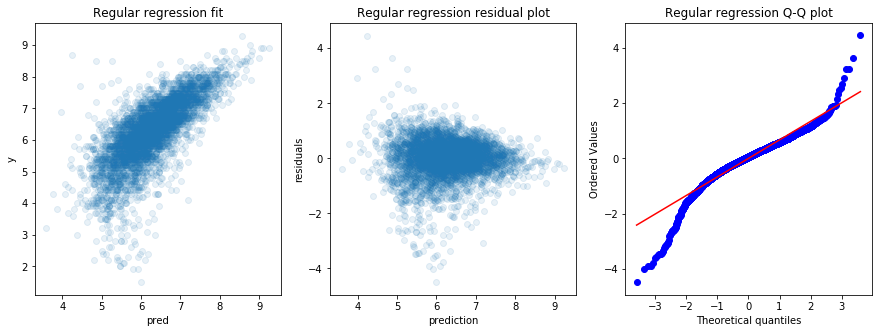

In [94]:
#Diagnostic plots
plt.figure(figsize=(15,5))

X, y = data, target

rgr = LinearRegression()
rgr.fit(X, y)
pred = rgr.predict(X)

plt.subplot(1, 3, 1)
plt.scatter(pred, y, alpha = 0.1)
plt.title("Regular regression fit")
plt.xlabel("pred")
plt.ylabel("y")

plt.subplot(1, 3, 2)
res = (y - pred)
plt.scatter(pred, res, alpha = 0.1)
plt.title("Regular regression residual plot")
plt.xlabel("prediction")
plt.ylabel("residuals")

plt.subplot(1, 3, 3)
pred = rgr.predict(X)
stats.probplot(res, dist="norm", plot=plt)
plt.title("Regular regression Q-Q plot");

In [95]:
#Statmodels analysis
model = sm.OLS(y,X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     19.17
Date:                Mon, 05 Feb 2018   Prob (F-statistic):               0.00
Time:                        11:41:14   Log-Likelihood:                -4686.5
No. Observations:                4455   AIC:                             9901.
Df Residuals:                    4191   BIC:                         1.159e+04
Df Model:                         263                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
budget                  -2.8220      0.142    -19.901      0.000      -3.100      -2.544
gross_usa               -0.0268      0.110     -0.244      0.807      -0.242       0.189
runtime                  3.5331      0.187     18.861      0.000       3.166       3.900
votes                    4.2532      0.133     32.062      0.000       3.993       4.513
Action                  -0.1688      0.035     -4.827      0.000      -0.237      -0.100
Adventure               -0.0392      0.038     -1.027      0.305      -0.114       0.036
Animation                0.9979      0.068     14.630      0.000       0.864       1.132
Biography                0.1614      0.053      3.059      0.002       0.058       0.265
Comedy                  -0.1136      0.030     -3.728      0.000      -0.173      -0.054
Crime                    0.0382      0.033      1.159      0.247      -0.026       0.103
Drama                    0.3885      0.029     13.310      0.000       0.331       0.446
Family                  -0.1561      0.063     -2.497      0.013      -0.279      -0.034
Fantasy                 -0.1167      0.039     -3.013      0.003      -0.193      -0.041
History                 -0.0383      0.072     -0.535      0.593      -0.179       0.102
Horror                  -0.5124      0.043    -11.817      0.000      -0.597      -0.427
Music                   -0.0762      0.059     -1.281      0.200      -0.193       0.040
Musical                  0.0126      0.083      0.153      0.878      -0.149       0.175
Mystery                  0.0344      0.038      0.902      0.367      -0.040       0.109
Romance                 -0.1148      0.029     -3.935      0.000      -0.172      -0.058
Sci-Fi                  -0.1029      0.039     -2.609      0.009      -0.180      -0.026
Sport                   -0.0429      0.061     -0.708      0.479      -0.162       0.076
Thriller                -0.1778      0.032     -5.527      0.000      -0.241      -0.115
War                      0.0529      0.071      0.744      0.457      -0.087       0.192
Western                 -0.0116      0.095     -0.122      0.903      -0.198       0.175
G                        4.9579      0.521      9.522      0.000       3.937       5.979
NC-17                    4.3012      0.608      7.076      0.000       3.110       5.493
NOT RATED                5.0779      0.519      9.779      0.000       4.060       6.096
PG                       4.8584      0.514      9.449      0.000       3.850       5.866
PG-13                    4.7027      0.514      9.142      0.000       3.694       5.711
R                        4.8341      0.515      9.392      0.000       3.825       5.843
TV-14                    4.5668      0.884      5.166      0.000       2.834       6.300
TV-G                     5.7320      0.886      6.472    

# Models

In [96]:
#This function will help me calculate the RMSE
def RMSE(actuals, preds): 
    return np.sqrt(np.mean((actuals - preds)**2))

In [97]:
#Divide the data into training, test, and validation sets.
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=42) 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)

kf = KFold(n_splits=5, shuffle=True, random_state = 71)

## Model 1 - Basic Linear Regression

In [98]:
#Initialize the model
lr_model_1 = LinearRegression()
lr_model_1.fit(X_train, y_train);

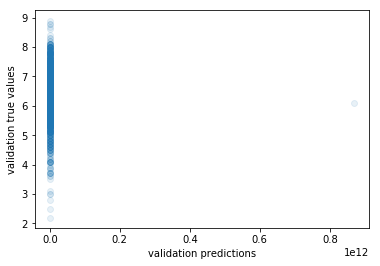

In [99]:
#Perform basic validation and look at the results.
plt.scatter(lr_model_1.predict(X_val), y_val, alpha=.1)
plt.plot(np.linspace(0,12,0.1),np.linspace(0,12,0.1))
plt.xlabel("validation predictions")
plt.ylabel("validation true values");

In [100]:
#Look at the model's RMSE and r^2
print("Basic Linear Regression RMSE: %.3f" %(RMSE(y_val, lr_model_1.predict(X_val))))
print("Basic Linear Regression r^2: %.3f" %(lr_model_1.score(X_val, y_val)))

Basic Linear Regression RMSE: 29132101864.350
Basic Linear Regression r^2: -841843855973043535872.000


In [101]:
#Perform cross-validation
X_cv, y_cv = np.array(X), np.array(y)

cv_lm_r2s = []
cv_lm_rmse = []

for train_ind, val_ind in kf.split(X_cv, y_cv):
    
    X_cv_train, y_cv_train = X_cv[train_ind], y_cv[train_ind]
    X_val, y_val = X_cv[val_ind], y_cv[val_ind] 
    
    lr_model_1.fit(X_cv_train, y_cv_train)
    
    cv_lm_r2s.append(lr_model_1.score(X_val, y_val))
    cv_lm_rmse.append(RMSE(y_val, lr_model_1.predict(X_val)))

#Check RMSE and r^2 for cross-validation.    
print('Basic Linear Regression mean cv r^2: %.3f +- %.3f' %(np.mean(cv_lm_r2s),np.std(cv_lm_r2s)))
print('Basic Linear Regression mean cv RMSE: %.3f +- %.3f' %(np.mean(cv_lm_rmse),np.std(cv_lm_rmse)))

Basic Linear Regression mean cv r^2: -390618376927479284629504.000 +- 781236753854958569259008.000
Basic Linear Regression mean cv RMSE: 285037498709.812 +- 570074997418.205


In [102]:
#Check r^2 on the test set.
lr_model_1.score(X_test, y_test)

-1.8372362374262964e+22

## Model 2 - LASSO regularization

In [103]:
#Define alphavec for LASSO and Ridge CV
alphavec = 10**np.linspace(-5,5,10)

In [104]:
#Scale the training set
std = StandardScaler()
std.fit(X_train);

In [105]:
#Transform the training data for LASSO regularization
X_lasso_train = std.transform(X_train)
X_lasso_val = std.transform(X_val)

In [106]:
#Initialize the model and perform cross-validation using in-built methods.
lr_model_2 = LassoCV(alphas = alphavec, cv=5)
lr_model_2.fit(X_lasso_train,y_train)

LassoCV(alphas=array([  1.00000e-05,   1.29155e-04,   1.66810e-03,   2.15443e-02,
         2.78256e-01,   3.59381e+00,   4.64159e+01,   5.99484e+02,
         7.74264e+03,   1.00000e+05]),
    copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [107]:
#Look at the coefficients.
list(zip(X_train.columns, lr_model_2.coef_))

[('budget', -0.3842582540675118),
 ('gross_usa', -0.015059611919166375),
 ('runtime', 0.32420525556244023),
 ('votes', 0.59357152457656115),
 ('Action', -0.072568283514365395),
 ('Adventure', 0.0),
 ('Animation', 0.22859854797993764),
 ('Biography', 0.035086134342950881),
 ('Comedy', -0.04149289857044975),
 ('Crime', 0.019618832178403472),
 ('Drama', 0.19121980762787044),
 ('Family', -0.027022859033316051),
 ('Fantasy', -0.047004771152537046),
 ('History', 0.0021113911257677528),
 ('Horror', -0.14453060666180487),
 ('Music', -0.014391434960420439),
 ('Musical', -0.013209896771206844),
 ('Mystery', 0.018323114137318422),
 ('Romance', -0.044282569967429582),
 ('Sci-Fi', -0.032642920466891941),
 ('Sport', -0.01120642819027117),
 ('Thriller', -0.082119671846944547),
 ('War', -0.0),
 ('Western', 0.017719645235623683),
 ('G', 0.010171152476760164),
 ('NC-17', -0.030976592195708627),
 ('NOT RATED', 0.023620976475389407),
 ('PG', -0.0),
 ('PG-13', -0.056769194674358217),
 ('R', 0.0020790452300

In [108]:
#Look at a single validation sert.
val_set_pred_2 = lr_model_2.predict(X_lasso_val)

In [109]:
#Check RMSE and r^2 for LASSO regularization for one validation set.
print('LASSO mean cv r^2: %.3f' %lr_model_2.score(X_lasso_val, y_val))
print('LASSO mean cv RMSE: %.3f' %np.sqrt(np.mean((val_set_pred_2 - y_val)**2)))

LASSO mean cv r^2: 0.578
LASSO mean cv RMSE: 0.661


In [110]:
#Check the model's r^2 on the test data.
lr_model_2.score(std.transform(X_test), y_test)

0.46870712587714491

## Model 3 - Ridge Regularization

In [111]:
#Scale the data
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [112]:
#Initialize the model and perform built-in cross-validation.
lr_model_3 = RidgeCV(alphas = alphavec, cv=5)
lr_model_3.fit(X_train_scaled,y_train)

RidgeCV(alphas=array([  1.00000e-05,   1.29155e-04,   1.66810e-03,   2.15443e-02,
         2.78256e-01,   3.59381e+00,   4.64159e+01,   5.99484e+02,
         7.74264e+03,   1.00000e+05]),
    cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [113]:
#Check the coefficients
list(zip(X_train.columns,lr_model_3.coef_))

[('budget', -0.35962525236291654),
 ('gross_usa', -0.0086728583173759383),
 ('runtime', 0.31097819591813297),
 ('votes', 0.56376237359823422),
 ('Action', -0.077106942131295667),
 ('Adventure', 0.0011710215237396722),
 ('Animation', 0.22487891818540465),
 ('Biography', 0.038855716097684193),
 ('Comedy', -0.045358765119149304),
 ('Crime', 0.021341012990827031),
 ('Drama', 0.19029152971765434),
 ('Family', -0.032267625047848726),
 ('Fantasy', -0.047769991586305217),
 ('History', 0.0035097988154842974),
 ('Horror', -0.1423506877474407),
 ('Music', -0.016790083867970849),
 ('Musical', -0.014769502245882807),
 ('Mystery', 0.019531879456521035),
 ('Romance', -0.042817012501522395),
 ('Sci-Fi', -0.032267375871105571),
 ('Sport', -0.013297187184121437),
 ('Thriller', -0.085593876637135996),
 ('War', -0.0018543823838148526),
 ('Western', 0.018264787231446054),
 ('G', 0.017093507768297607),
 ('NC-17', -0.030389388825421568),
 ('NOT RATED', 0.031906803776851046),
 ('PG', 0.010413713343795749),
 (

In [114]:
#Look at one validation set...
val_set_pred_3 = lr_model_3.predict(X_val_scaled)

In [115]:
#... and check its RMSE and r^2
print('Ridge mean cv r^2: %.3f' %lr_model_3.score(X_val_scaled, y_val))
print('Ridge mean cv RMSE: %.3f' %np.sqrt(np.mean((val_set_pred_3 - y_val)**2)))

Ridge mean cv r^2: 0.574
Ridge mean cv RMSE: 0.664


In [116]:
#Test the model on the test set
lr_model_3.score(std.transform(X_test), y_test)

0.46309073331114203

## Model 4 - Linear Regression With Polynomials

In [117]:
#I will perform 5-fold cross-validation by using a loop, so I am going to create lists for r^2 and rmse, 
#and then calculate RMSE on the means of both lists.
cv_poly_r2s = []
cv_poly_rmse = []

for train_ind, val_ind in kf.split(X_cv,y_cv):
    
    X_train, y_train = X_cv[train_ind], y_cv[train_ind]
    X_val, y_val = X_cv[val_ind], y_cv[val_ind] 
    
    #polynomial degree 2
    poly = PolynomialFeatures(degree=2) 

    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)

    lm_poly = LinearRegression()
    lm_poly.fit(X_train_poly, y_train)
    
    cv_poly_r2s.append(lm_poly.score(X_val_poly, y_val))
    cv_poly_rmse.append(RMSE(y_val, lm_poly.predict(X_val_poly)))

#Check r^2 and RMSE     
print('Polynomial mean cv r^2: %.3f +- %.3f' %(np.mean(cv_poly_r2s),np.std(cv_poly_r2s)))
print('Polynomial mean cv RMSE: %.3f +- %.3f' %(np.mean(cv_poly_rmse),np.std(cv_poly_rmse)))

Polynomial mean cv r^2: -66867356962743293837312.000 +- 76194012717305330401280.000
Polynomial mean cv RMSE: 196427617853.836 +- 164857700736.781


In [118]:
#Check r^2 on the test data.
lm_poly.score(poly.transform(X_test), y_test)

-8.5515031335976445e+22